In [1]:
import pandas as pd
import xgboost
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

In [170]:
CLINICAL_DATA_DIR = '/data/rnd1712/dataset/breast/lnm/breast-dataset-v1.0/LNM.xlsx'
o_df = pd.read_excel(CLINICAL_DATA_DIR, engine="openpyxl")
o_df.columns

Index(['p_id', 'serial', 'age', 'surgical_name', 'histologic_type',
       'cancer_loc', 'cancer_count', 'cancer_size', 'ng', 'hg', 'hg_score_1',
       'hg_score_2', 'hg_score_3', 'cis_status', 'cis_type', 't_category',
       'lnm_in_surgery', 'lnm_count_in_surgery', 'lnm_size_in_surgery',
       'n_category', 'm_category', 'ajcc_stage', 'er_status', 'er_score',
       'pr_status', 'pr_score', 'ki-67', 'her2', 'her2_inc', 'her2_sish',
       'her2_sish_ratio', 'brca_mutation', 'axillary_lnm', 'surgical_recur',
       'organ_Tx', 'death', 'slide_directory'],
      dtype='object')

In [171]:
o_df.head()

,p_id,serial,age,surgical_name,histologic_type,cancer_loc,cancer_count,cancer_size,ng,hg,...,her2,her2_inc,her2_sish,her2_sish_ratio,brca_mutation,axillary_lnm,surgical_recur,organ_Tx,death,slide_directory
0,1,BC_01_0002,51,1,1,1,1,22.0,3.0,3.0,...,0.0,NaN,NaN,NaN,NaN,0,0,0,0,/data/118/MOHW/breast/dataset/BC_01/distribute...
1,2,BC_01_0011,55,2,2,2,1,23.0,2.0,2.0,...,0.0,30.0,NaN,NaN,NaN,0,0,0,0,/data/118/MOHW/breast/dataset/BC_01/distribute...
2,3,BC_01_0397,60,1,1,2,1,23.0,2.0,2.0,...,0.0,0.0,NaN,NaN,NaN,0,0,0,0,/data/118/MOHW/breast/dataset/BC_01/distribute...
3,4,BC_01_0398,58,1,1,2,1,13.0,2.0,2.0,...,0.0,30.0,NaN,NaN,NaN,0,0,0,0,/data/118/MOHW/breast/dataset/BC_01/distribute...
4,5,BC_01_0404,72,1,1,2,1,13.0,2.0,1.0,...,0.0,30.0,NaN,NaN,NaN,0,0,0,0,/data/118/MOHW/breast/dataset/BC_01/distribute...


In [324]:
#clinical_df = o_df[['p_id', 'cancer_size', 'hg', 'er_status', 'er_score', 'her2']].copy()
clinical_df = o_df[['p_id', 'er_status', 'er_score', 'her2']].copy()
clinical_df.head()

,p_id,er_status,er_score,her2
0,1,0.0,NaN,0.0
1,2,1.0,90.0,0.0
2,3,1.0,80.0,0.0
3,4,1.0,100.0,0.0
4,5,1.0,95.0,0.0


In [2]:
CLINICAL_DATA_PATH_LIST = [
    '/data/rnd1712/dataset/breast/lnm/breast-dataset-v1.0/breast-patches2/testset/results.csv'
]

In [3]:
df = None
for idx, path in enumerate(CLINICAL_DATA_PATH_LIST):
    tmp = pd.read_csv(path)

    if idx == 0:
        df = tmp
    else:
        df = df.append(tmp, ignore_index=True)
df.shape

(62, 13)

In [4]:
df.head()

,Unnamed: 0,A,B,D,E,mean_m_prob,mean_n_prob,std_m_prob,std_n_prob,sum_m_prob,sum_n_prob,tiles,wsi_id
0,0,0.0,18.0,0.0,0.0,0.750732,0.249268,0.028570,0.028570,1084.056922,359.943077,1444.0,229.0
1,1,0.0,7.0,0.0,0.0,0.718805,0.281195,0.039801,0.039801,763.371435,298.628565,1062.0,247.0
2,2,0.0,0.0,0.0,0.0,0.707030,0.292970,0.036572,0.036572,36.765539,15.234461,52.0,163.0
3,3,0.0,0.0,0.0,0.0,0.731882,0.268118,0.024699,0.024699,174.187940,63.812060,238.0,165.0
4,4,0.0,3.0,0.0,0.0,0.750163,0.249837,0.022964,0.022964,603.131025,200.868975,804.0,168.0


In [7]:
df.columns

Index(['Unnamed: 0', 'A', 'B', 'D', 'E', 'mean_m_prob', 'mean_n_prob',
       'std_m_prob', 'std_n_prob', 'sum_m_prob', 'sum_n_prob', 'tiles',
       'wsi_id'],
      dtype='object')

In [9]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [10]:
df['wsi_id'] = df['wsi_id'].astype(int)

In [14]:
df["metastasis"] = np.nan

In [15]:
NORMAL_SLIDES = [163,168,180,194,205,229,239,247,269,280,293,297,315,323,326,333,346,
165,175,185,196,214,230,240,252,279,283,294,311,316,325,332,336,347]
METASTASIS_SLIDES = [101,104,107,111,118,121,125,128,145,154,164,17,19,21,24,28,32,38,42,45,48,55,57,70,73,87,89,98]

In [173]:
for id_ in NORMAL_SLIDES:
    df.loc[df["wsi_id"] == id_, "metastasis"] = 0
    
for id_ in METASTASIS_SLIDES:
    df.loc[df["wsi_id"] == id_, "metastasis"] = 1
    
df["metastasis"] = pd.to_numeric(df["metastasis"])
df['metastasis'] = df['metastasis'].astype(int)

In [20]:
df.head()

,A,B,D,E,mean_m_prob,mean_n_prob,std_m_prob,std_n_prob,sum_m_prob,sum_n_prob,tiles,wsi_id,metastasis
0,0.0,18.0,0.0,0.0,0.750732,0.249268,0.028570,0.028570,1084.056922,359.943077,1444.0,229,0
1,0.0,7.0,0.0,0.0,0.718805,0.281195,0.039801,0.039801,763.371435,298.628565,1062.0,247,0
2,0.0,0.0,0.0,0.0,0.707030,0.292970,0.036572,0.036572,36.765539,15.234461,52.0,163,0
3,0.0,0.0,0.0,0.0,0.731882,0.268118,0.024699,0.024699,174.187940,63.812060,238.0,165,0
4,0.0,3.0,0.0,0.0,0.750163,0.249837,0.022964,0.022964,603.131025,200.868975,804.0,168,0


In [325]:
clinical_df.rename(columns = {'p_id':'wsi_id'}, inplace=True)

In [326]:
m_df = pd.merge(left = df , right = clinical_df, how = "inner", on = "wsi_id")
m_df.head()

,A,B,D,E,mean_m_prob,mean_n_prob,std_m_prob,std_n_prob,sum_m_prob,sum_n_prob,tiles,wsi_id,metastasis,er_status,er_score,her2
0,0.0,18.0,0.0,0.0,0.750732,0.249268,0.028570,0.028570,1084.056922,359.943077,1444.0,229,0,1.0,95.0,0.0
1,0.0,7.0,0.0,0.0,0.718805,0.281195,0.039801,0.039801,763.371435,298.628565,1062.0,247,0,1.0,95.0,1.0
2,0.0,0.0,0.0,0.0,0.707030,0.292970,0.036572,0.036572,36.765539,15.234461,52.0,163,0,1.0,95.0,0.0
3,0.0,0.0,0.0,0.0,0.731882,0.268118,0.024699,0.024699,174.187940,63.812060,238.0,165,0,1.0,100.0,1.0
4,0.0,3.0,0.0,0.0,0.750163,0.249837,0.022964,0.022964,603.131025,200.868975,804.0,168,0,1.0,95.0,0.0


In [349]:
m_df.dropna(inplace=True)

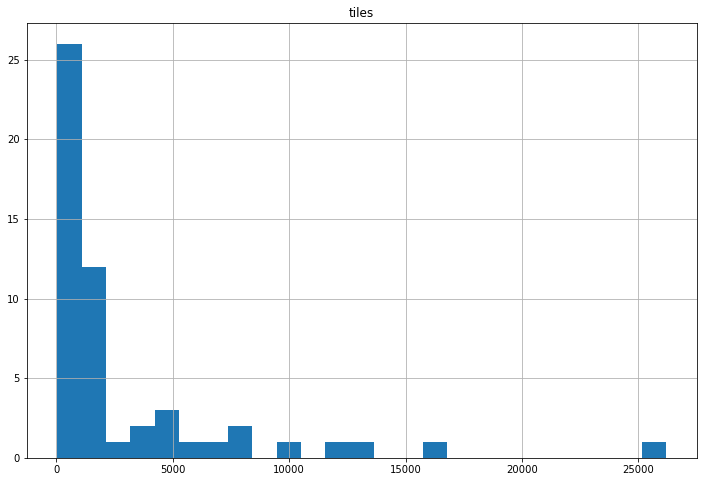

In [194]:
hist = m_df.hist(column = ['tiles'], bins=25, figsize=(12,8))

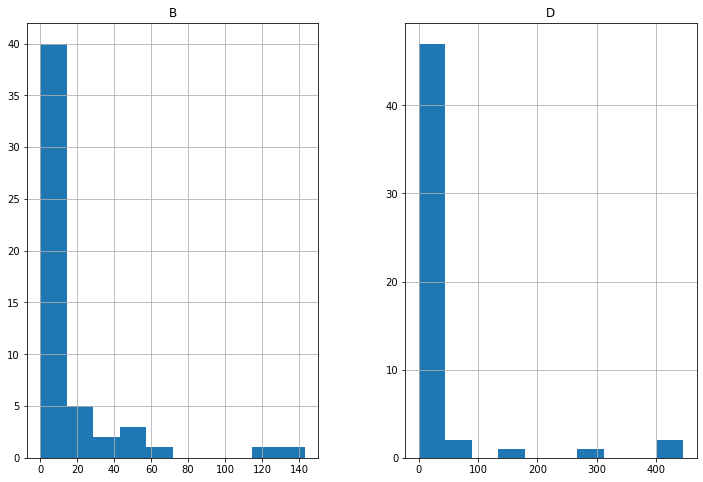

In [195]:
hist = m_df[['B', 'D']].hist(bins=10, figsize=(12,8))

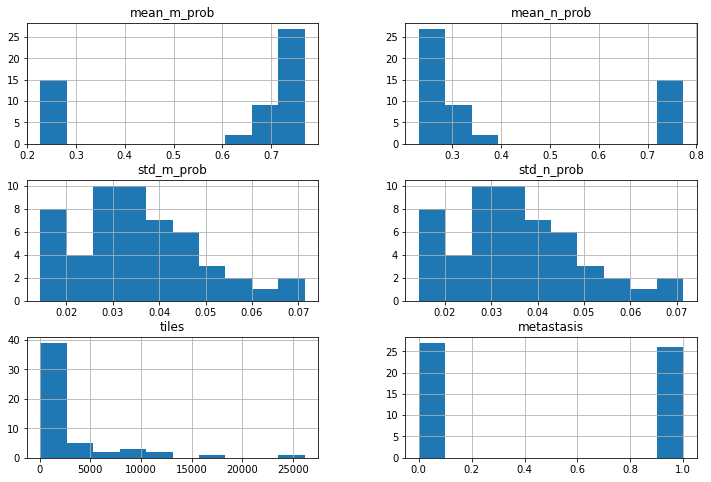

In [372]:
hist = m_df[['mean_m_prob','mean_n_prob','std_m_prob','std_n_prob','tiles','metastasis']].hist(bins=10, figsize=(12,8))

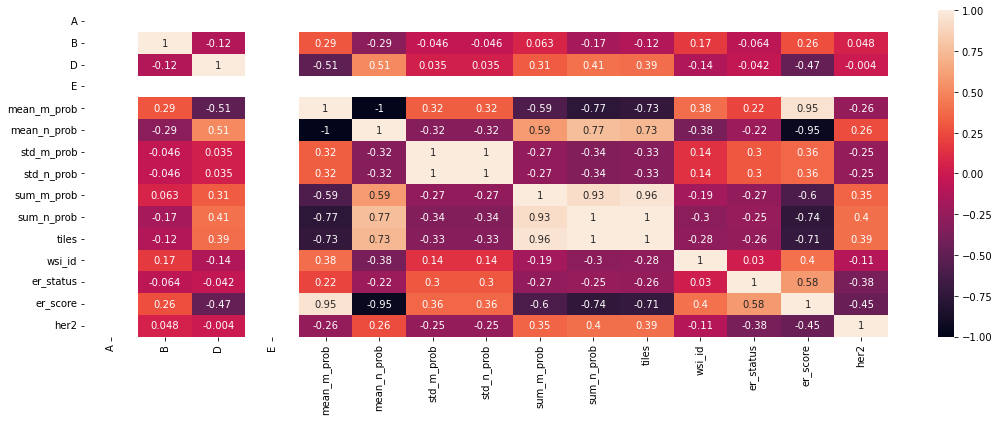

In [327]:
# Visualizing a Pandas Correlation Matrix Using Seaborn
corr_df = m_df.drop(['metastasis'], axis=1)
matrix = corr_df.corr().round(3)

fig, ax = plt.subplots(figsize=(18, 6))         # Sample figsize in inches
sns.heatmap(matrix, annot=True, ax=ax)
plt.show()

In [198]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 0 to 61
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A            53 non-null     float64
 1   B            53 non-null     float64
 2   D            53 non-null     float64
 3   E            53 non-null     float64
 4   mean_m_prob  53 non-null     float64
 5   mean_n_prob  53 non-null     float64
 6   std_m_prob   53 non-null     float64
 7   std_n_prob   53 non-null     float64
 8   sum_m_prob   53 non-null     float64
 9   sum_n_prob   53 non-null     float64
 10  tiles        53 non-null     float64
 11  wsi_id       53 non-null     int64  
 12  metastasis   53 non-null     int64  
 13  er_status    53 non-null     float64
 14  er_score     53 non-null     float64
 15  her2         53 non-null     float64
dtypes: float64(14), int64(2)
memory usage: 7.0 KB


In [359]:
test_df = m_df.drop(['mean_n_prob', 'std_n_prob', 'sum_m_prob','sum_n_prob'], axis=1)

In [366]:
train, test = train_test_split(test_df, test_size=0.2)
print(len(train), len(test))

X_train = train.drop(['metastasis'], axis=1)
y_train = train['metastasis']
X_test = test.drop(['metastasis'], axis=1)
y_test = test['metastasis']

print(f'Train. X: {len(X_train)}, Y: {len(y_train)}')
print(f'Test. X: {len(X_test)}, Y: {len(y_test)}')

42 11
Train. X: 42, Y: 42
Test. X: 11, Y: 11


In [367]:
model = xgboost.XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[15:55:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [368]:
y_pred = model.predict(X_test)

In [369]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
( tn, fp, fn, tp )

(5, 0, 2, 4)

In [370]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average=None)

array([0.83333333, 0.8       ])

In [371]:
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print('macro: {}, micro: {}, wieghted: {}'.format(f1_macro, f1_micro, f1_weighted))

macro: 0.8166666666666667, micro: 0.8181818181818182, wieghted: 0.8151515151515152


# Results

## All fields
macro: 0.9150326797385622, micro: 0.9230769230769231, wieghted: 0.9250879839115134  

## except normal fields
macro: 0.8194444444444444, micro: 0.8461538461538461, wieghted: 0.8568376068376069  
macro: 0.8452380952380951, micro: 0.8461538461538461, wieghted: 0.8443223443223442  
macro: 0.9090909090909091, micro: 0.9090909090909091, wieghted: 0.9090909090909091  
macro: 0.8035714285714285, micro: 0.8181818181818182, wieghted: 0.8279220779220778  

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [356]:
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [357]:
y_pred = clf.predict(X_test)

In [358]:
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print('macro: {}, micro: {}, wieghted: {}'.format(f1_macro, f1_micro, f1_weighted))

macro: 1.0, micro: 1.0, wieghted: 1.0


depth 4: macro: 0.9090909090909091, micro: 0.9090909090909091, wieghted: 0.9090909090909091  
depth 7: macro: 0.8952380952380952, micro: 0.9090909090909091, wieghted: 0.9125541125541126